In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import utils

import os, sys, datetime, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib

In [5]:
nib.__version__

'2.3.0'

## Identify data location, subject, run, etc

In [6]:
raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/NB_LGN_20180524/Nb_20180524/sub-NB/")

In [7]:
out_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/')

In [8]:
fmriprep_dir = os.path.abspath(os.path.join(out_dir, 'fmriprep'))

In [9]:
sub = "NB"
ses = "20180524"
task = "hemi"

### Current progress as of 20181212

 * The goal is to compare the GLM and coherence approaches to identifying visually responsive voxels
 * But the GLM approach cannot be done here because the event files don't exist, and can't be recreated
   * Well, we have some of the hemifield outputs in .mat, but not all... and the ones we have weren't run with the correct parameters (cycle duration, # cycles, length etc)
   * So we'd have to trim an unknown amount etc to make the data worth analyzing
 * So, do the coherence approach based on the cycle duration we have so at least that code works
 * BUT ALSO, make sure to fix the hemifield and mp code to generate events files
 * And also fix the presentation code to have it trigger on a TTL

In [10]:
anat = os.path.join(fmriprep_dir, f"sub-{sub}", 'anat', f"sub-{sub}_T1w_preproc.nii.gz")

In [11]:
bolds, masks, eventfiles, TR, confounds = utils.get_files(sub, ses, task, raw_data_dir, fmriprep_dir)

BOLDS: 4
['/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-01_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-02_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-03_bold_space-T1w_preproc.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-04_bold_space-T1w_preproc.nii.gz']
Masks: 4
['/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-01_bold_space-T1w_brainmask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-02_bold_space-T1w_brainmask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_2

In [11]:
bolds

['/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-01_bold_space-T1w_preproc.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-02_bold_space-T1w_preproc.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-03_bold_space-T1w_preproc.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-04_bold_space-T1w_preproc.nii.gz']

### Run the GLM

In [12]:
glm_command = f"python glm_fixedeffects_level12.py {raw_data_dir} {out_dir} {sub} {ses} {task} T1w"

In [13]:
print(glm_command)

python glm_fixedeffects_level12.py /Users/smerdis/data/LGN/NB_LGN_20180524/Nb_20180524/sub-NB /Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives NB 20180524 hemi T1w


### View the results

In [ ]:
#mrvanat = os.path.join(out_dir, "mrvista", "T1w.nii.gz")
#func = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_bold_space-T1w_preproc.nii.gz")
#vROI = os.path.join(out_dir, "mrvista", "vROI1.nii.gz")
#mROI = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_lLGN_roi_manual.nii.gz")

In [14]:
wf_dir = f"{out_dir}/nipype_{sub}_{ses}_{task}/hemifield/modelfit"
datasink_dir = os.path.join(wf_dir, 'datasink')
print(datasink_dir)

/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/nipype_NB_20180524_hemi/hemifield/modelfit/datasink


In [15]:
!ls "{datasink_dir}"

ls: /Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/nipype_NB_20180524_hemi/hemifield/modelfit/datasink: No such file or directory


In [ ]:
utils.view_results(datasink_dir, [3], anat, func)

## Coherence analysis to identify LGN voxels responding at hemifield alternation frequency

In [15]:
bold_file = bolds[0]

In [17]:
img = nib.load(bold_file)

In [18]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  81 102  92 139   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.          1.75        1.75        1.57500005  2.25        1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 8
cal_max         : 2058.864990234375
cal_min         : -83.84920501708984
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.4.1).'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0

In [17]:
img_data = img.get_fdata()

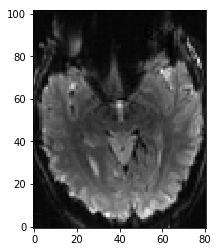

In [18]:
plt.imshow(img_data[:, :, 40, 44].T, cmap="gray", origin="lower")

In [19]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [20]:
n_timepoints = img.shape[-1]

In [21]:
print(nvox, n_timepoints)

760104 139


In [22]:
#img_flat = np.reshape(img_data, (nvox, -1))
#img_flat[:10, 0]
2.25*6

13.5

### Begin Coherence analysis in nitime

In [13]:
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta

#### build a timeseries object out of the stimulus alternation waveform

In [14]:
cycle_duration = 32 # This was the 7T setting I accidentally ran for NB (should be 27s)
freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
total_len = img.shape[-1]*TR # seconds

t = np.arange(0.0, total_len, TR)
hemifield_alternation_sinusoid = np.sin(freq*2*np.pi*t)
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)

NameError: name 'img' is not defined

In [ ]:
ts.UniformTime??

In [38]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)

In [39]:
hemi_ts??

In [40]:
hemi_ts.time

UniformTime([   0.  ,    2.25,    4.5 ,    6.75,    9.  ,   11.25,   13.5 ,
               15.75,   18.  ,   20.25,   22.5 ,   24.75,   27.  ,   29.25,
               31.5 ,   33.75,   36.  ,   38.25,   40.5 ,   42.75,   45.  ,
               47.25,   49.5 ,   51.75,   54.  ,   56.25,   58.5 ,   60.75,
               63.  ,   65.25,   67.5 ,   69.75,   72.  ,   74.25,   76.5 ,
               78.75,   81.  ,   83.25,   85.5 ,   87.75,   90.  ,   92.25,
               94.5 ,   96.75,   99.  ,  101.25,  103.5 ,  105.75,  108.  ,
              110.25,  112.5 ,  114.75,  117.  ,  119.25,  121.5 ,  123.75,
              126.  ,  128.25,  130.5 ,  132.75,  135.  ,  137.25,  139.5 ,
              141.75,  144.  ,  146.25,  148.5 ,  150.75,  153.  ,  155.25,
              157.5 ,  159.75,  162.  ,  164.25,  166.5 ,  168.75,  171.  ,
              173.25,  175.5 ,  177.75,  180.  ,  182.25,  184.5 ,  186.75,
              189.  ,  191.25,  193.5 ,  195.75,  198.  ,  200.25,  202.5 ,
            

#### build a timeseries object out of the fmri data

In [34]:
bold_time_series = nfio.time_series_from_file(bold_file, TR=TR, normalize='percent', verbose=True)

Reading /Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/fmriprep/sub-NB/ses-20180524/func/sub-NB_ses-20180524_task-hemi_run-01_bold_space-T1w_preproc.nii.gz


In [35]:
# Verify timeseries laoded by nitime is same size as that loaded by base nibabel above
assert(np.all(bold_time_series.shape==img.shape))

In [36]:
bold_time_series

TimeSeries:UniformTime([   0.  ,    2.25,    4.5 ,    6.75,    9.  ,   11.25,   13.5 ,
               15.75,   18.  ,   20.25,   22.5 ,   24.75,   27.  ,   29.25,
               31.5 ,   33.75,   36.  ,   38.25,   40.5 ,   42.75,   45.  ,
               47.25,   49.5 ,   51.75,   54.  ,   56.25,   58.5 ,   60.75,
               63.  ,   65.25,   67.5 ,   69.75,   72.  ,   74.25,   76.5 ,
               78.75,   81.  ,   83.25,   85.5 ,   87.75,   90.  ,   92.25,
               94.5 ,   96.75,   99.  ,  101.25,  103.5 ,  105.75,  108.  ,
              110.25,  112.5 ,  114.75,  117.  ,  119.25,  121.5 ,  123.75,
              126.  ,  128.25,  130.5 ,  132.75,  135.  ,  137.25,  139.5 ,
              141.75,  144.  ,  146.25,  148.5 ,  150.75,  153.  ,  155.25,
              157.5 ,  159.75,  162.  ,  164.25,  166.5 ,  168.75,  171.  ,
              173.25,  175.5 ,  177.75,  180.  ,  182.25,  184.5 ,  186.75,
              189.  ,  191.25,  193.5 ,  195.75,  198.  ,  200.25,  202.5 ,
 

### begin coherence analysis

In [53]:
test_hemi_stim = np.vstack((hemifield_alternation_sinusoid, hemifield_alternation_sinusoid))

In [54]:
test_hemi_stim.shape

(2, 139)

In [63]:
test_ts = ts.TimeSeries(test_hemi_stim, sampling_interval=TR)

In [64]:
corr_analyzer = nta.CorrelationAnalyzer(test_hemi_stim)

In [65]:
corr_analyzer

CorrelationAnalyzer()

In [66]:
corr_analyzer.corrcoef

array([[ 1.,  1.],
       [ 1.,  1.]])

In [12]:
c1 = nta.CoherenceAnalyzer(test_hemi_stim)

NameError: name 'nta' is not defined

## Assigning voxels within an ROI to M/P

In [ ]:
copefile = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_mp/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'
ROIfile = mROI

In [ ]:
def assign_mp_command(cope, roimask, pct_thresh, roi_below, roi_above, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(roimask)
    print(f"python assign_mp.py {cope} {roimask} {pct_thresh} {roi_below} {roi_above} {out_dir}")

def assign_voxels(infile, rois, split_pct):
    """Assign voxels to an ROI based on the percentile of intensity they fall in.
    
    rois should be a list of length 2, split_pcts should be a list of length 1
    
    e.g. assign_voxels_percentile(infile, ['M', 'P'], 80)"""
    from nipype.interfaces.fsl import ImageMaths
    stats = ImageMaths()
    stats.inputs.in_file = infile
    stats.inputs.op_string = f"-thr {split_pct} -bin {roi_above}"
    print(stats.cmdline)

In [ ]:
assign_mp_command(copefile, ROIfile, 80, 'M', 'P')

In [ ]:
masked_cope = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_hemi/hemifield/modelfit/datasink/cope_masked.nii.gz'

In [ ]:
assign_voxels_percentile(masked_cope, ['M', 'P'], 80)

### Plotting stat maps

In [ ]:
from nilearn.plotting import plot_stat_map

In [ ]:
cc=(22, -16, -10)

In [ ]:
tstat = "/Users/smerdis/data/LGN/BIDS/NB_20180524/derivatives/nipype_NB_20180524_mp/hemifield/modelfit/datasink/results_dir/_modelestimate4/results/cope3.nii.gz"

In [ ]:
plot_stat_map(
    tstat, title='tstat1 for modelestimate0',
    bg_img=anat, threshold=5, cut_coords=cc, display_mode='ortho', dim=-1)

In [ ]:
plot_stat_map(
    tstat, title='tstat1 for modelestimate0',
    bg_img=anat, threshold=1.5, cut_coords=cc, display_mode='ortho', dim=-1)

In [ ]:
plot_stat_map(
    tstat, title='tstat1 for modelestimate0',
    bg_img=anat, threshold=2, cut_coords=cc, display_mode='ortho', dim=-1)

In [ ]:
plot_stat_map(
    tstat, title='tstat1 for modelestimate0',
    bg_img=anat, threshold=2, display_mode='x', cut_coords=range(20, 27), dim=-1, output_file='lgn_slices_x_thr2.png')

In [ ]:
plot_stat_map(
    tstat, title='tstat1 for modelestimate0',
    bg_img=anat, threshold=2, display_mode='y', cut_coords=range(-18, -14), dim=-1, output_file='lgn_slices_y_thr2.png')